In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [70]:
# Dependencies
from pymongo import MongoClient
import pandas as pd
import numpy as np

from urls_list import * #where all urls and paths are saved

In [71]:
import warnings
warnings.filterwarnings("ignore")

## Read the historic rental data

In [72]:
client = MongoClient(db_connection_string)
records = list(client.ETLInsight["HistoricRental"].find({}, {'_id':0}))

In [95]:
DF = pd.DataFrame(records)

In [96]:
#Replace all white spaces or nothing at all to NaN
DF.replace(r'^\s*$', np.nan, regex=True, inplace=True)
#Replace None with NaN
DF = DF.fillna(value=np.nan)

## Missing Data Analysis

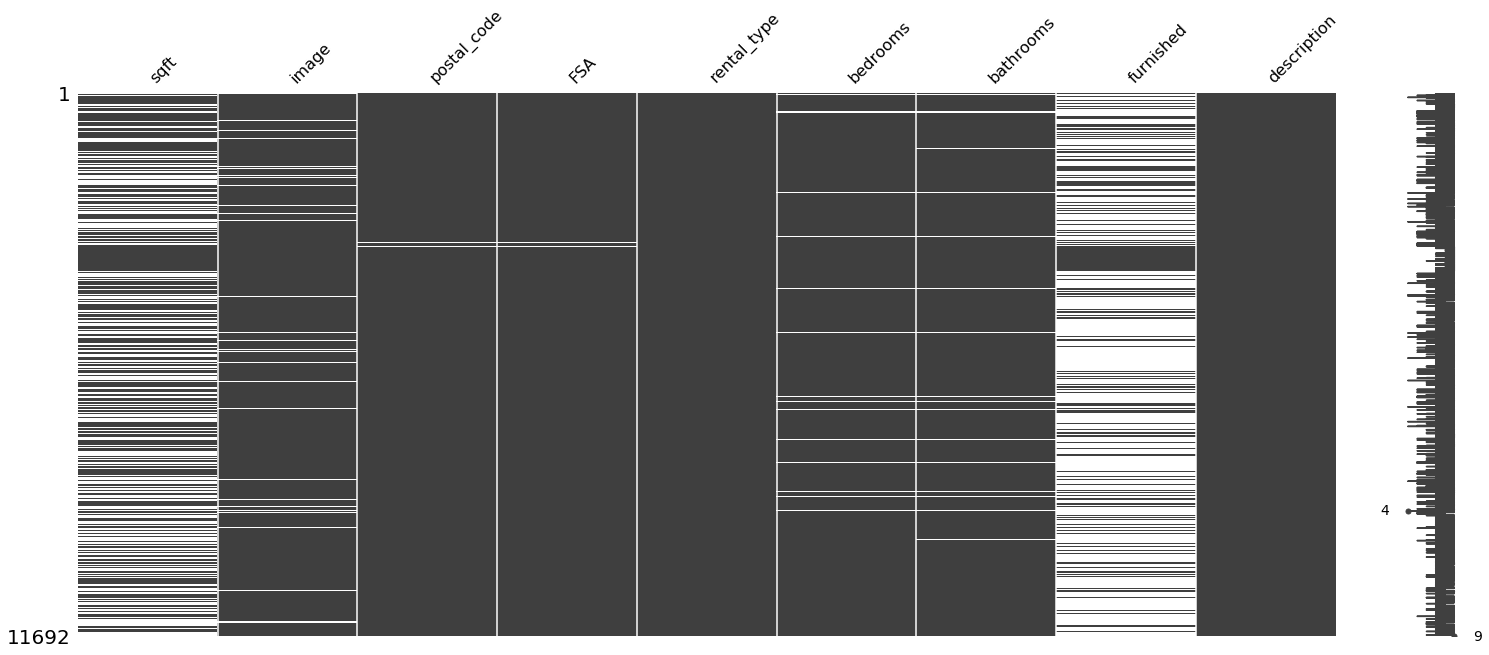

In [97]:
missingdata_col = DF.columns[DF.isnull().any()].tolist()
import matplotlib
import missingno as msno
%matplotlib inline
msno.matrix(DF[missingdata_col])

#### Make FSA and rental_type mandatory. If they are not retrieved in the rental posting, ML will not run, citing an exception

In [98]:
DF.drop(DF[DF[['FSA', 'rental_type']].isna().any(axis=1)].index, inplace=True)

# [1373, 3234, 3320, 3332, 3347, 3452, 3474, 3512, 3569, 3574, 3616,
#             3678, 3703, 3711, 3765, 3795, 3816, 3825, 7601, 8374, 8473, 8680,
#             9053, 9366, 9632]

DF = DF[DF['FSA'].str.startswith('M')]

## Type casting

In [99]:
DF['price'] = DF['price'].astype('int')

#Convert post_published_date to week of the month
from datetime import datetime
DF['post_published_date'] = DF['post_published_date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

#New features
DF['posted_week_of_month'] = DF['post_published_date'].map(lambda x: x.day//7 +1)

## Missing value handling

In [100]:
DF['furnished'] = DF['furnished'].fillna(value="NOT_MENTIONED")
DF['furnished'] = DF['furnished'].replace(to_replace=True, value='YES')
DF['furnished'] = DF['furnished'].replace(to_replace=False, value='NO')
#Convert image url to image or not?
DF['image'] = DF['image'].notna()

## Removing outliers

In [101]:
num_columns = ['sqft', 'bedrooms', 'bathrooms', 'posted_week_of_month']
cat_columns = ['image', 'FSA', 'rental_type', 'furnished', 'pet_friendly']
nlp_scope_columns = ['title', 'description']

#DF['price'].plot(kind='box',showfliers=False,showmeans=True)
#DF[num_columns].quantile(0.995)
#DF[num_columns].quantile(0.005)
#DF['price'].quantile(0.995)
#DF['price'].quantile(0.005)

#Remove sqft > 3000 and less than 200
#Remove price > 10000 and less than 100

DF = DF[(DF['price']<=10000) & (DF['price']>=100)]
DF.drop(DF[(DF['sqft']<200) | (DF['sqft']>3000)].index, axis=0, inplace=True)

## Basic Transformations

In [102]:
DF.reset_index(drop=True, inplace=True)
X = DF[num_columns + cat_columns]
Y = DF['price']

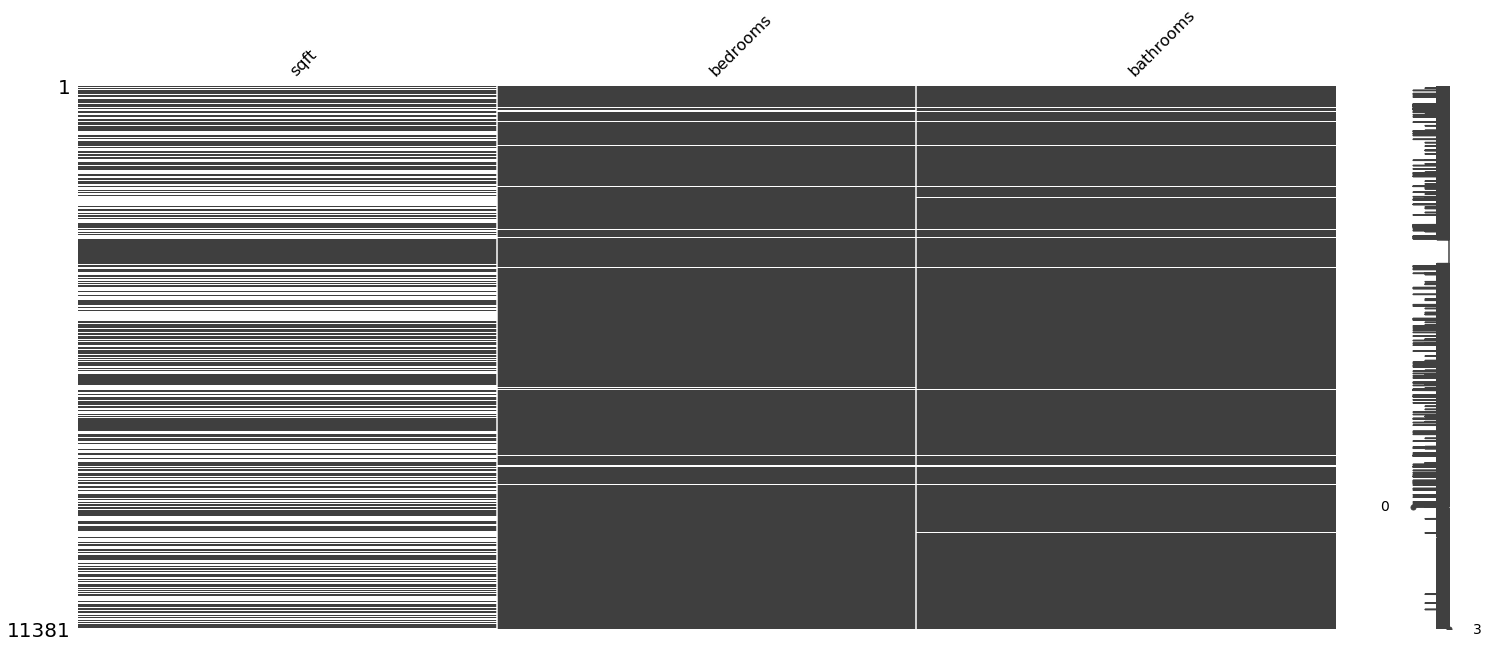

In [103]:
missingdata_col = X.columns[X.isnull().any()].tolist()
import matplotlib
import missingno as msno
%matplotlib inline
msno.matrix(X[missingdata_col])

### One Hot Encoding

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
##OHE
enc = OneHotEncoder()
##OHE Fit
enc.fit(X[cat_columns])
##OHE Transform
ohe_output = enc.transform(X[cat_columns]).toarray()
##Retrieve OHE labels
ohe_dict = {f'x{index}':col for index,col in enumerate(cat_columns)}
ohe_labels = [ohe_dict[feature.split('_')[0]]+'_'+feature.split('_')[1] for feature in enc.get_feature_names()]
X = pd.concat([X, pd.DataFrame(ohe_output, columns=ohe_labels)], axis=1)
X.drop(cat_columns, axis=1, inplace=True)

OneHotEncoder()

## Filter only selected columns

In [105]:
selected_columns = ['sqft', 'bedrooms', 'bathrooms', 'image_False', 'FSA_M1B', 'FSA_M1M',
       'FSA_M1P', 'FSA_M1V', 'FSA_M1W', 'FSA_M2M', 'FSA_M3C', 'FSA_M3K',
       'FSA_M4E', 'FSA_M4V', 'FSA_M4W', 'FSA_M5G', 'FSA_M5J', 'FSA_M5R',
       'FSA_M5S', 'FSA_M5V', 'FSA_M6B', 'FSA_M6E', 'FSA_M6G', 'FSA_M6J',
       'FSA_M6K', 'FSA_M6M', 'FSA_M6P', 'rental_type_apartment',
       'rental_type_condo', 'rental_type_house', 'rental_type_loft',
       'rental_type_townhouse', 'furnished_NOT', 'furnished_YES',
       'pet_friendly_False']
X = X[selected_columns]

## Train Test Split

In [106]:
seed = 100
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3)


## Imputation of sqft based on bedrooms and bathrooms

In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
scaler = StandardScaler()
scaler.fit(X_train)
columns = X_train.columns
X_train = pd.DataFrame(scaler.transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

imputer = KNNImputer(n_neighbors=9)
imputer.fit(X_train[['sqft', 'bedrooms','bathrooms']])
X_train.loc[:,['sqft', 'bedrooms','bathrooms']] = imputer.transform(X_train[['sqft', 'bedrooms','bathrooms']])
X_test.loc[:,['sqft', 'bedrooms','bathrooms']] = imputer.transform(X_test[['sqft', 'bedrooms','bathrooms']])


StandardScaler()

KNNImputer(n_neighbors=9)

## DeepLearning

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K

number_inputs = X_train.shape[1]
model = Sequential()
model.add(Dropout(0.1, input_shape=(number_inputs,)))
#model.add(Dense(units=50,activation='relu', kernel_initializer='normal', input_dim=number_inputs))
model.add(Dense(units=50,activation='relu', kernel_initializer='normal'))
model.add(Dense(units=20,activation='relu', kernel_initializer='normal'))
model.add(Dense(units=1, kernel_initializer='normal'))
y_train = y_train.astype('float')
y_test = y_test.astype('float')
model.summary()

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(optimizer='adam',
              #loss='mean_squared_error',
              loss = root_mean_squared_error,
              metrics=[coeff_determination])

# Fit (train) the model
hist = model.fit(
    X_train,
    y_train,
    epochs=1000,
    shuffle=True,
    verbose=2,
    validation_split=0.3
)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 50)                1800      
_________________________________________________________________
dense_49 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 21        
Total params: 2,841
Trainable params: 2,841
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
175/175 - 0s - loss: 2292.6340 - coeff_determination: -8.7031e+00 - val_loss: 2263.5256 - val_coeff_determination: -7.7877e+00
Epoch 2/1000
175/175 - 0s - loss: 2052.5583 - coeff_determination: -6.7483e+00 - val_loss: 1756.3945 - val_co

Epoch 58/1000
175/175 - 0s - loss: 507.4010 - coeff_determination: 0.5564 - val_loss: 509.9629 - val_coeff_determination: 0.5950
Epoch 59/1000
175/175 - 0s - loss: 506.1329 - coeff_determination: 0.5565 - val_loss: 509.2165 - val_coeff_determination: 0.5946
Epoch 60/1000
175/175 - 0s - loss: 509.2119 - coeff_determination: 0.5519 - val_loss: 506.7037 - val_coeff_determination: 0.5986
Epoch 61/1000
175/175 - 0s - loss: 511.5395 - coeff_determination: 0.5592 - val_loss: 506.9082 - val_coeff_determination: 0.5976
Epoch 62/1000
175/175 - 0s - loss: 506.3424 - coeff_determination: 0.5500 - val_loss: 511.1688 - val_coeff_determination: 0.5933
Epoch 63/1000
175/175 - 0s - loss: 507.3227 - coeff_determination: 0.5517 - val_loss: 506.0156 - val_coeff_determination: 0.5997
Epoch 64/1000
175/175 - 0s - loss: 499.9764 - coeff_determination: 0.5630 - val_loss: 505.2923 - val_coeff_determination: 0.5993
Epoch 65/1000
175/175 - 0s - loss: 517.0548 - coeff_determination: 0.5389 - val_loss: 507.3860 - 

Epoch 122/1000
175/175 - 0s - loss: 493.6797 - coeff_determination: 0.5769 - val_loss: 495.8250 - val_coeff_determination: 0.6133
Epoch 123/1000
175/175 - 0s - loss: 494.1741 - coeff_determination: 0.5750 - val_loss: 492.9368 - val_coeff_determination: 0.6166
Epoch 124/1000
175/175 - 0s - loss: 494.8893 - coeff_determination: 0.5774 - val_loss: 496.3888 - val_coeff_determination: 0.6123
Epoch 125/1000
175/175 - 0s - loss: 494.7798 - coeff_determination: 0.5736 - val_loss: 494.3931 - val_coeff_determination: 0.6143
Epoch 126/1000
175/175 - 0s - loss: 489.7333 - coeff_determination: 0.5823 - val_loss: 493.9414 - val_coeff_determination: 0.6152
Epoch 127/1000
175/175 - 0s - loss: 494.3950 - coeff_determination: 0.5794 - val_loss: 493.1573 - val_coeff_determination: 0.6162
Epoch 128/1000
175/175 - 0s - loss: 491.1206 - coeff_determination: 0.5818 - val_loss: 494.5056 - val_coeff_determination: 0.6158
Epoch 129/1000
175/175 - 0s - loss: 496.8865 - coeff_determination: 0.5664 - val_loss: 493

175/175 - 0s - loss: 482.4189 - coeff_determination: 0.5955 - val_loss: 489.7567 - val_coeff_determination: 0.6204
Epoch 186/1000
175/175 - 0s - loss: 492.6122 - coeff_determination: 0.5786 - val_loss: 488.0516 - val_coeff_determination: 0.6219
Epoch 187/1000
175/175 - 0s - loss: 489.0588 - coeff_determination: 0.5869 - val_loss: 490.2229 - val_coeff_determination: 0.6198
Epoch 188/1000
175/175 - 0s - loss: 482.8067 - coeff_determination: 0.5933 - val_loss: 494.4257 - val_coeff_determination: 0.6143
Epoch 189/1000
175/175 - 0s - loss: 483.3366 - coeff_determination: 0.5896 - val_loss: 489.9382 - val_coeff_determination: 0.6212
Epoch 190/1000
175/175 - 1s - loss: 484.2694 - coeff_determination: 0.5898 - val_loss: 492.7264 - val_coeff_determination: 0.6173
Epoch 191/1000
175/175 - 0s - loss: 481.9345 - coeff_determination: 0.5871 - val_loss: 488.0326 - val_coeff_determination: 0.6222
Epoch 192/1000
175/175 - 0s - loss: 479.6840 - coeff_determination: 0.5970 - val_loss: 487.0732 - val_coe

Epoch 249/1000
175/175 - 0s - loss: 482.0006 - coeff_determination: 0.5967 - val_loss: 492.0454 - val_coeff_determination: 0.6186
Epoch 250/1000
175/175 - 0s - loss: 476.9071 - coeff_determination: 0.6010 - val_loss: 482.2888 - val_coeff_determination: 0.6288
Epoch 251/1000
175/175 - 0s - loss: 480.5310 - coeff_determination: 0.5954 - val_loss: 485.2757 - val_coeff_determination: 0.6256
Epoch 252/1000
175/175 - 0s - loss: 483.2269 - coeff_determination: 0.5916 - val_loss: 486.5201 - val_coeff_determination: 0.6244
Epoch 253/1000
175/175 - 0s - loss: 477.4455 - coeff_determination: 0.5978 - val_loss: 490.1336 - val_coeff_determination: 0.6201
Epoch 254/1000
175/175 - 0s - loss: 481.5364 - coeff_determination: 0.5918 - val_loss: 491.9222 - val_coeff_determination: 0.6178
Epoch 255/1000
175/175 - 0s - loss: 474.3158 - coeff_determination: 0.6061 - val_loss: 482.0265 - val_coeff_determination: 0.6307
Epoch 256/1000
175/175 - 0s - loss: 480.4309 - coeff_determination: 0.5960 - val_loss: 483

175/175 - 0s - loss: 466.1065 - coeff_determination: 0.6197 - val_loss: 481.6548 - val_coeff_determination: 0.6309
Epoch 313/1000
175/175 - 0s - loss: 475.5340 - coeff_determination: 0.6015 - val_loss: 477.7440 - val_coeff_determination: 0.6348
Epoch 314/1000
175/175 - 0s - loss: 467.8577 - coeff_determination: 0.6114 - val_loss: 485.3963 - val_coeff_determination: 0.6269
Epoch 315/1000
175/175 - 0s - loss: 465.4431 - coeff_determination: 0.6218 - val_loss: 484.2831 - val_coeff_determination: 0.6288
Epoch 316/1000
175/175 - 0s - loss: 463.2834 - coeff_determination: 0.6204 - val_loss: 478.9020 - val_coeff_determination: 0.6340
Epoch 317/1000
175/175 - 0s - loss: 459.6025 - coeff_determination: 0.6303 - val_loss: 476.4092 - val_coeff_determination: 0.6381
Epoch 318/1000
175/175 - 0s - loss: 464.9754 - coeff_determination: 0.6182 - val_loss: 480.1527 - val_coeff_determination: 0.6329
Epoch 319/1000
175/175 - 0s - loss: 461.3820 - coeff_determination: 0.6181 - val_loss: 477.8917 - val_coe

Epoch 376/1000
175/175 - 0s - loss: 462.7530 - coeff_determination: 0.6195 - val_loss: 474.3967 - val_coeff_determination: 0.6403
Epoch 377/1000
175/175 - 0s - loss: 466.8182 - coeff_determination: 0.6006 - val_loss: 475.4485 - val_coeff_determination: 0.6394
Epoch 378/1000
175/175 - 0s - loss: 462.9588 - coeff_determination: 0.6218 - val_loss: 476.3485 - val_coeff_determination: 0.6380
Epoch 379/1000
175/175 - 0s - loss: 464.2773 - coeff_determination: 0.6167 - val_loss: 483.4725 - val_coeff_determination: 0.6298
Epoch 380/1000
175/175 - 0s - loss: 458.6467 - coeff_determination: 0.6250 - val_loss: 480.7580 - val_coeff_determination: 0.6320
Epoch 381/1000
175/175 - 0s - loss: 468.4133 - coeff_determination: 0.6210 - val_loss: 476.3267 - val_coeff_determination: 0.6373
Epoch 382/1000
175/175 - 0s - loss: 461.5381 - coeff_determination: 0.6260 - val_loss: 472.4594 - val_coeff_determination: 0.6401
Epoch 383/1000
175/175 - 0s - loss: 457.6483 - coeff_determination: 0.6155 - val_loss: 475

175/175 - 0s - loss: 464.1877 - coeff_determination: 0.6178 - val_loss: 474.3918 - val_coeff_determination: 0.6404
Epoch 440/1000
175/175 - 0s - loss: 455.3082 - coeff_determination: 0.6341 - val_loss: 470.2609 - val_coeff_determination: 0.6447
Epoch 441/1000
175/175 - 0s - loss: 453.1443 - coeff_determination: 0.6413 - val_loss: 481.2934 - val_coeff_determination: 0.6311
Epoch 442/1000
175/175 - 0s - loss: 454.7872 - coeff_determination: 0.6278 - val_loss: 473.8055 - val_coeff_determination: 0.6396
Epoch 443/1000
175/175 - 0s - loss: 452.7790 - coeff_determination: 0.6331 - val_loss: 470.7896 - val_coeff_determination: 0.6424
Epoch 444/1000
175/175 - 0s - loss: 449.4865 - coeff_determination: 0.6345 - val_loss: 471.3983 - val_coeff_determination: 0.6426
Epoch 445/1000
175/175 - 0s - loss: 459.6019 - coeff_determination: 0.6355 - val_loss: 479.1065 - val_coeff_determination: 0.6339
Epoch 446/1000
175/175 - 0s - loss: 454.6781 - coeff_determination: 0.6229 - val_loss: 476.5636 - val_coe

Epoch 503/1000
175/175 - 0s - loss: 453.1938 - coeff_determination: 0.6435 - val_loss: 468.4023 - val_coeff_determination: 0.6454
Epoch 504/1000
175/175 - 1s - loss: 451.9600 - coeff_determination: 0.6411 - val_loss: 473.1042 - val_coeff_determination: 0.6400
Epoch 505/1000
175/175 - 0s - loss: 457.2016 - coeff_determination: 0.6231 - val_loss: 468.0779 - val_coeff_determination: 0.6467
Epoch 506/1000
175/175 - 1s - loss: 454.2591 - coeff_determination: 0.6373 - val_loss: 468.3832 - val_coeff_determination: 0.6457
Epoch 507/1000
175/175 - 0s - loss: 454.9287 - coeff_determination: 0.6388 - val_loss: 468.9335 - val_coeff_determination: 0.6445
Epoch 508/1000
175/175 - 0s - loss: 444.3909 - coeff_determination: 0.6458 - val_loss: 471.0684 - val_coeff_determination: 0.6424
Epoch 509/1000
175/175 - 0s - loss: 448.3723 - coeff_determination: 0.6452 - val_loss: 474.1070 - val_coeff_determination: 0.6388
Epoch 510/1000
175/175 - 0s - loss: 454.0760 - coeff_determination: 0.6318 - val_loss: 468

175/175 - 0s - loss: 449.7068 - coeff_determination: 0.6408 - val_loss: 465.7434 - val_coeff_determination: 0.6481
Epoch 567/1000
175/175 - 0s - loss: 445.0282 - coeff_determination: 0.6455 - val_loss: 470.1680 - val_coeff_determination: 0.6430
Epoch 568/1000
175/175 - 0s - loss: 453.0808 - coeff_determination: 0.6327 - val_loss: 469.1729 - val_coeff_determination: 0.6441
Epoch 569/1000
175/175 - 0s - loss: 446.3781 - coeff_determination: 0.6478 - val_loss: 465.4903 - val_coeff_determination: 0.6484
Epoch 570/1000
175/175 - 1s - loss: 444.3241 - coeff_determination: 0.6512 - val_loss: 471.6283 - val_coeff_determination: 0.6408
Epoch 571/1000
175/175 - 0s - loss: 450.9610 - coeff_determination: 0.6269 - val_loss: 468.2894 - val_coeff_determination: 0.6454
Epoch 572/1000
175/175 - 0s - loss: 447.3369 - coeff_determination: 0.6397 - val_loss: 468.0318 - val_coeff_determination: 0.6458
Epoch 573/1000
175/175 - 0s - loss: 445.0263 - coeff_determination: 0.6378 - val_loss: 471.4542 - val_coe

Epoch 630/1000
175/175 - 0s - loss: 442.7514 - coeff_determination: 0.6322 - val_loss: 467.5648 - val_coeff_determination: 0.6464
Epoch 631/1000
175/175 - 0s - loss: 440.2702 - coeff_determination: 0.6508 - val_loss: 470.9045 - val_coeff_determination: 0.6424
Epoch 632/1000
175/175 - 0s - loss: 440.7796 - coeff_determination: 0.6469 - val_loss: 471.1069 - val_coeff_determination: 0.6417
Epoch 633/1000
175/175 - 0s - loss: 443.5516 - coeff_determination: 0.6570 - val_loss: 463.9023 - val_coeff_determination: 0.6501
Epoch 634/1000
175/175 - 0s - loss: 442.6240 - coeff_determination: 0.6435 - val_loss: 470.3736 - val_coeff_determination: 0.6419
Epoch 635/1000
175/175 - 0s - loss: 443.3858 - coeff_determination: 0.6476 - val_loss: 465.9545 - val_coeff_determination: 0.6479
Epoch 636/1000
175/175 - 0s - loss: 442.6632 - coeff_determination: 0.6489 - val_loss: 469.6269 - val_coeff_determination: 0.6441
Epoch 637/1000
175/175 - 0s - loss: 444.6967 - coeff_determination: 0.6437 - val_loss: 464

175/175 - 0s - loss: 436.9576 - coeff_determination: 0.6537 - val_loss: 463.6588 - val_coeff_determination: 0.6499
Epoch 694/1000
175/175 - 0s - loss: 448.6776 - coeff_determination: 0.6350 - val_loss: 465.9620 - val_coeff_determination: 0.6462
Epoch 695/1000
175/175 - 0s - loss: 443.9178 - coeff_determination: 0.6307 - val_loss: 464.8118 - val_coeff_determination: 0.6471
Epoch 696/1000
175/175 - 0s - loss: 440.0797 - coeff_determination: 0.6450 - val_loss: 465.6488 - val_coeff_determination: 0.6474
Epoch 697/1000
175/175 - 0s - loss: 441.5315 - coeff_determination: 0.6418 - val_loss: 472.7675 - val_coeff_determination: 0.6388
Epoch 698/1000
175/175 - 0s - loss: 440.4516 - coeff_determination: 0.6553 - val_loss: 464.0083 - val_coeff_determination: 0.6481
Epoch 699/1000
175/175 - 0s - loss: 431.2418 - coeff_determination: 0.6578 - val_loss: 470.4865 - val_coeff_determination: 0.6405
Epoch 700/1000
175/175 - 0s - loss: 434.9955 - coeff_determination: 0.6545 - val_loss: 462.0353 - val_coe

Epoch 757/1000
175/175 - 1s - loss: 443.3336 - coeff_determination: 0.6581 - val_loss: 471.8268 - val_coeff_determination: 0.6396
Epoch 758/1000
175/175 - 1s - loss: 434.9179 - coeff_determination: 0.6112 - val_loss: 466.7494 - val_coeff_determination: 0.6443
Epoch 759/1000
175/175 - 0s - loss: 435.3648 - coeff_determination: 0.6577 - val_loss: 464.4316 - val_coeff_determination: 0.6474
Epoch 760/1000
175/175 - 0s - loss: 442.1284 - coeff_determination: 0.6397 - val_loss: 463.8008 - val_coeff_determination: 0.6486
Epoch 761/1000
175/175 - 0s - loss: 428.8957 - coeff_determination: 0.6579 - val_loss: 468.6202 - val_coeff_determination: 0.6421
Epoch 762/1000
175/175 - 0s - loss: 450.1769 - coeff_determination: 0.6413 - val_loss: 466.8241 - val_coeff_determination: 0.6456
Epoch 763/1000
175/175 - 0s - loss: 446.3902 - coeff_determination: 0.6321 - val_loss: 466.2256 - val_coeff_determination: 0.6460
Epoch 764/1000
175/175 - 0s - loss: 436.9388 - coeff_determination: 0.6535 - val_loss: 472

175/175 - 0s - loss: 437.3495 - coeff_determination: 0.6556 - val_loss: 465.6792 - val_coeff_determination: 0.6447
Epoch 821/1000
175/175 - 0s - loss: 439.6869 - coeff_determination: 0.6387 - val_loss: 471.1928 - val_coeff_determination: 0.6379
Epoch 822/1000
175/175 - 0s - loss: 429.3507 - coeff_determination: 0.6650 - val_loss: 463.9450 - val_coeff_determination: 0.6473
Epoch 823/1000
175/175 - 0s - loss: 429.0830 - coeff_determination: 0.6627 - val_loss: 467.2284 - val_coeff_determination: 0.6443
Epoch 824/1000
175/175 - 0s - loss: 441.5905 - coeff_determination: 0.6529 - val_loss: 465.5054 - val_coeff_determination: 0.6458
Epoch 825/1000
175/175 - 1s - loss: 433.8946 - coeff_determination: 0.6577 - val_loss: 467.8405 - val_coeff_determination: 0.6432
Epoch 826/1000
175/175 - 0s - loss: 432.9895 - coeff_determination: 0.6546 - val_loss: 467.2486 - val_coeff_determination: 0.6424
Epoch 827/1000
175/175 - 0s - loss: 451.1972 - coeff_determination: 0.6445 - val_loss: 460.3396 - val_coe

Epoch 884/1000
175/175 - 0s - loss: 433.3765 - coeff_determination: 0.6566 - val_loss: 462.3110 - val_coeff_determination: 0.6478
Epoch 885/1000
175/175 - 0s - loss: 434.5625 - coeff_determination: 0.6570 - val_loss: 468.1013 - val_coeff_determination: 0.6409
Epoch 886/1000
175/175 - 0s - loss: 437.8961 - coeff_determination: 0.6412 - val_loss: 461.9316 - val_coeff_determination: 0.6472
Epoch 887/1000
175/175 - 0s - loss: 426.1651 - coeff_determination: 0.6661 - val_loss: 462.8551 - val_coeff_determination: 0.6460
Epoch 888/1000
175/175 - 0s - loss: 432.6795 - coeff_determination: 0.6707 - val_loss: 463.2164 - val_coeff_determination: 0.6473
Epoch 889/1000
175/175 - 0s - loss: 439.5902 - coeff_determination: 0.6481 - val_loss: 465.7807 - val_coeff_determination: 0.6441
Epoch 890/1000
175/175 - 0s - loss: 431.0750 - coeff_determination: 0.6667 - val_loss: 468.4423 - val_coeff_determination: 0.6394
Epoch 891/1000
175/175 - 0s - loss: 442.2804 - coeff_determination: 0.6438 - val_loss: 465

175/175 - 0s - loss: 440.0023 - coeff_determination: 0.6568 - val_loss: 467.3857 - val_coeff_determination: 0.6420
Epoch 948/1000
175/175 - 0s - loss: 428.7909 - coeff_determination: 0.6644 - val_loss: 471.6010 - val_coeff_determination: 0.6357
Epoch 949/1000
175/175 - 0s - loss: 429.9191 - coeff_determination: 0.6688 - val_loss: 473.6117 - val_coeff_determination: 0.6327
Epoch 950/1000
175/175 - 0s - loss: 440.8210 - coeff_determination: 0.6574 - val_loss: 463.7519 - val_coeff_determination: 0.6462
Epoch 951/1000
175/175 - 0s - loss: 425.7277 - coeff_determination: 0.6640 - val_loss: 466.8252 - val_coeff_determination: 0.6418
Epoch 952/1000
175/175 - 0s - loss: 437.3798 - coeff_determination: 0.6573 - val_loss: 467.1953 - val_coeff_determination: 0.6418
Epoch 953/1000
175/175 - 0s - loss: 433.6300 - coeff_determination: 0.6647 - val_loss: 464.8131 - val_coeff_determination: 0.6447
Epoch 954/1000
175/175 - 0s - loss: 436.1551 - coeff_determination: 0.6537 - val_loss: 470.8931 - val_coe

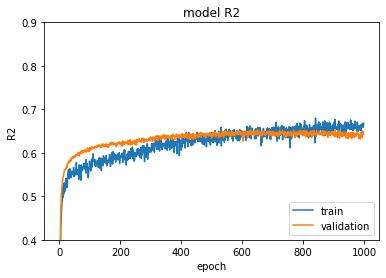

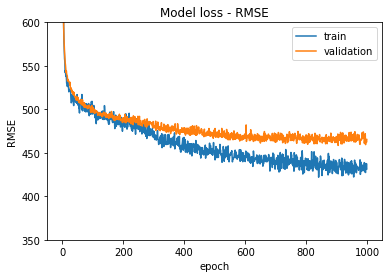

In [110]:
import matplotlib.pyplot as plt
# summarize history for accuracy
_=plt.plot(hist.history['coeff_determination'])
_=plt.plot(hist.history['val_coeff_determination'])
_=plt.title('model R2')
_=plt.ylabel('R2')
_=plt.xlabel('epoch')
_=plt.legend(['train', 'validation'], loc='lower right')
_=plt.ylim((0.4, 0.9))
_=plt.show()
# summarize history for loss
_=plt.plot(hist.history['loss'])
_=plt.plot(hist.history['val_loss'])
_=plt.title('Model loss - RMSE')
_=plt.ylabel('RMSE')
_=plt.xlabel('epoch')
_=plt.legend(['train', 'validation'], loc='upper right')
_=plt.ylim((350, 600))
_=plt.show()

In [111]:
model.evaluate(X_test, y_test)

107/107 [==============================] - 0s 2ms/step - loss: 484.3795 - coeff_determination: 0.6123


[484.3795166015625, 0.6122992038726807]

In [113]:
y_pred = model.predict(X_test).ravel()

In [115]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(y_test, y_pred)
np.sqrt(mean_squared_error(y_test, y_pred))

0.6302467807994612

519.4807916556229